## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.ensemble import RandomForestRegressor


In [3]:
train_url = 'data/train.csv'
test_url = 'data/test.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

train.head()

,id,Country,Year,Month,FoodPriceIndex
0,3501,Mexico,1971,11,0.0
1,60601,South Africa,2002,7,43.9
2,64399,Japan,2004,8,89.8
3,24227,France,1983,1,48.9
4,63779,Japan,2004,4,90.2


In [4]:
test.head()

,id,Country,Year,Month
0,99116,Italy,2023,4
1,97687,Denmark,2022,7
2,92061,United States,2019,6
3,95122,Netherlands,2021,2
4,92296,Italy,2019,8


### Checking Train Data

In [5]:
print("Train Data missing values:")
print(train.isna().sum())

print("Train Data duplicated: ", train.duplicated().sum())
print('-'*50)

print("Train Data Length: ", len(train))

Train Data missing values:
id                  0
Country             0
Year                0
Month               0
FoodPriceIndex    348
dtype: int64
Train Data duplicated:  0
--------------------------------------------------
Train Data Length:  11616


In [6]:
proportion_missing = train.isna().sum() / len(train)
print(proportion_missing)

id                0.000000
Country           0.000000
Year              0.000000
Month             0.000000
FoodPriceIndex    0.029959
dtype: float64


missing value < 0.05 berarti kita remove aja yang missing value (`Complete Case Analysis`)

In [7]:
from category_encoders import TargetEncoder

# Create copy of train data
# train = train.copy()

# Split data into rows with and without missing values
train_missing = train[train['FoodPriceIndex'].isna()]
train_not_missing = train[~train['FoodPriceIndex'].isna()]

# Prepare features for Random Forest
features = ['Year', 'Month'] 

# Target encode Country for both sets
te = TargetEncoder(cols=['Country'])
X_not_missing = te.fit_transform(train_not_missing[['Country'] + features], train_not_missing['FoodPriceIndex'])
X_missing = te.transform(train_missing[['Country'] + features])

# Train Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_not_missing, train_not_missing['FoodPriceIndex'])

# Predict missing values
predictions = rf.predict(X_missing)

# Fill missing values
train.loc[train['FoodPriceIndex'].isna(), 'FoodPriceIndex'] = predictions

print("Number of missing values after imputation:", train['FoodPriceIndex'].isna().sum())

Number of missing values after imputation: 0


In [8]:
len(train)

11616

### Checking Test Data

In [9]:
print("Test Data missing values:")
print(test.isna().sum())

print("Test Data duplicated: ", test.duplicated().sum())

print('-'*50)

print("Train Data Length: ", len(train))

Test Data missing values:
id         0
Country    0
Year       0
Month      0
dtype: int64
Test Data duplicated:  0
--------------------------------------------------
Train Data Length:  11616


## EDA

In [10]:
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns

print('Numerical Columns: ', num_cols)
print('Categorical Columns: ', cat_cols)

Numerical Columns:  Index(['id', 'Year', 'Month', 'FoodPriceIndex'], dtype='object')
Categorical Columns:  Index(['Country'], dtype='object')


In [11]:
train['Country'].value_counts()

Country
Mexico            528
South Africa      528
Taiwan, China     528
United Kingdom    528
Israel            528
Netherlands       528
Turkey            528
Spain             528
Finland           528
Italy             528
Greece            528
United States     528
Denmark           528
Austria           528
Portugal          528
Luxembourg        528
Switzerland       528
Germany           528
Canada            528
France            528
Japan             528
Sweden            528
Name: count, dtype: int64

In [12]:
test['Country'].value_counts()

Country
Italy             120
Denmark           120
Luxembourg        120
South Africa      120
Austria           120
Sweden            120
Germany           120
Spain             120
Mexico            120
France            120
Greece            120
Switzerland       120
Israel            120
United Kingdom    120
Turkey            120
Taiwan, China     120
Finland           120
Portugal          120
Canada            120
Netherlands       120
United States     120
Japan             120
Name: count, dtype: int64

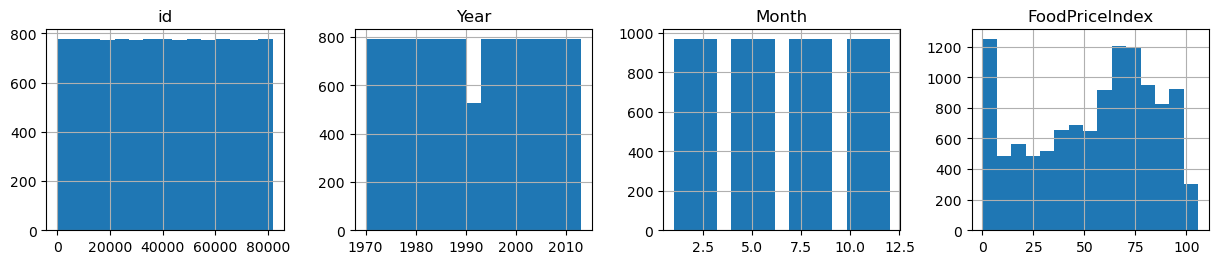

In [13]:
train[num_cols].hist(bins=15, figsize=(15, 6), layout=(2, 4));

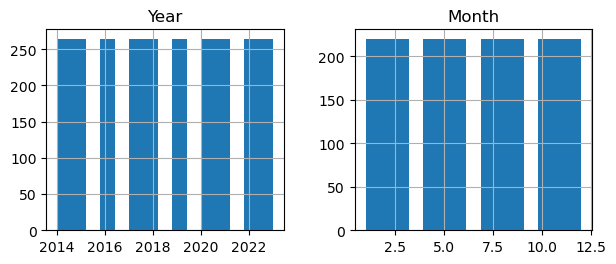

In [14]:
test[['Year', 'Month']].hist(bins=15, figsize=(15, 6), layout=(2, 4));

Might need to scale our data

### Heatmap Correlation

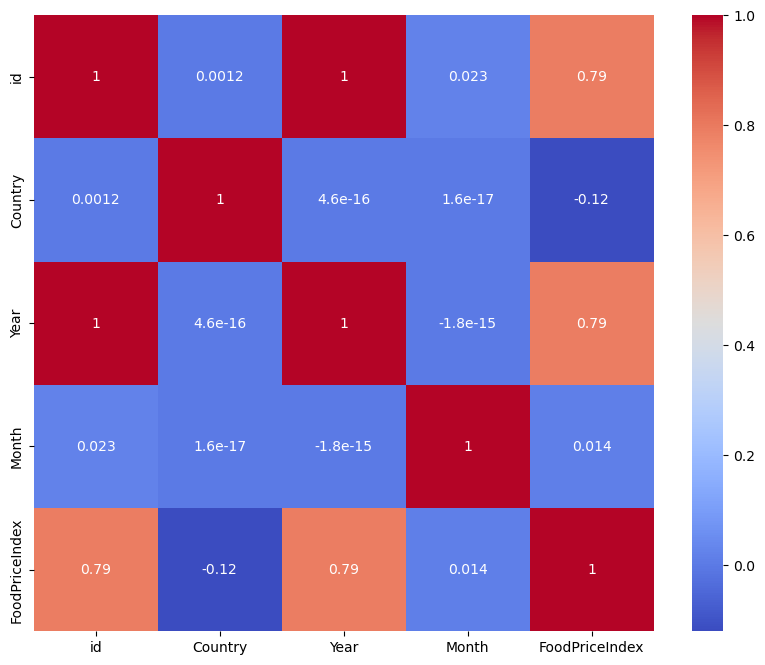

In [15]:
le = LabelEncoder()

train2 = train.copy()

train2['Country'] = le.fit_transform(train2['Country'])

corr_mat = train2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.show()

Yang paling berpengaruh dengan `FoodIndex` hanya Year dengan hasil korelasi pearson 0.79.

Method yang bisa diuji (Time Series Forecasting):
- Arima
- Prophet
- RandomForestRegressor

### Boxplot

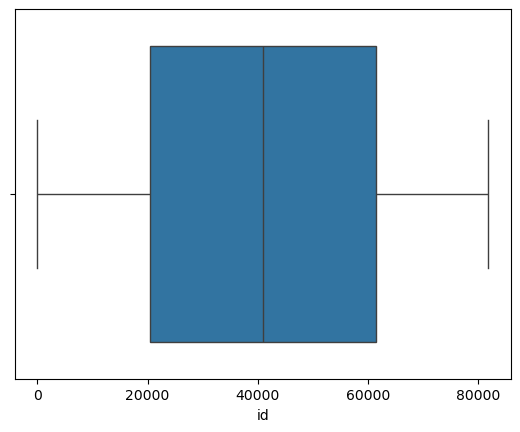

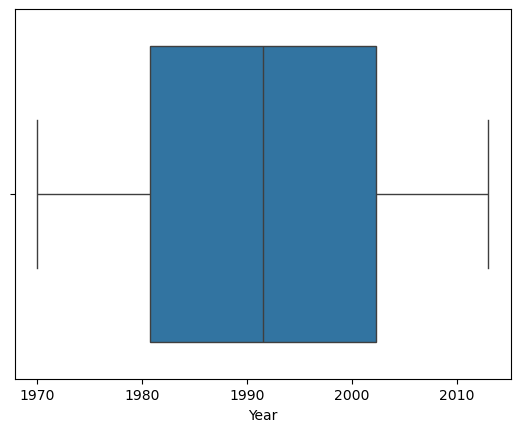

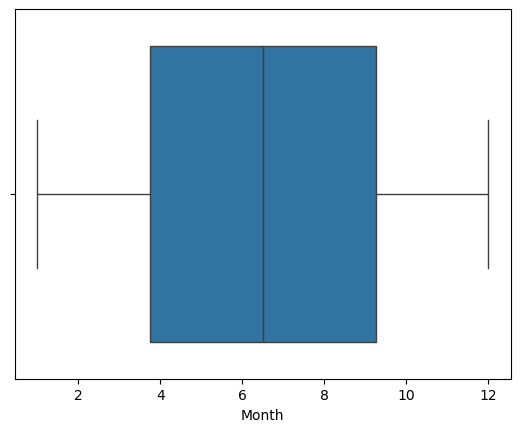

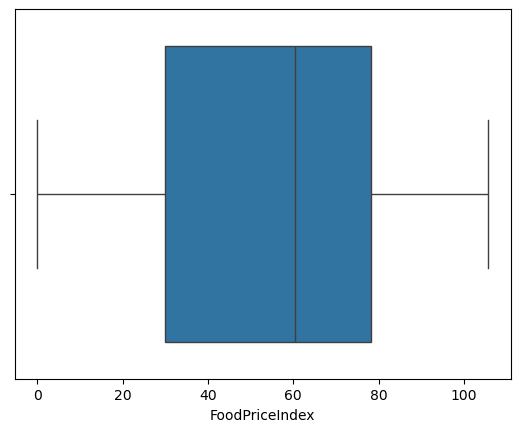

In [16]:
for col in num_cols:
    sns.boxplot(x=train[col])
    plt.show()

No need to handle outlier, karena data kita juga terdistribusi uniform.

## Modelling

In [17]:
X = train.drop(columns=['FoodPriceIndex', 'id'])
y = train['FoodPriceIndex']

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9873, 3), (1743, 3), (9873,), (1743,))

In [19]:
# set Country to TargetEncoder using category_encoders library
import category_encoders as ce


te = ce.TargetEncoder(cols=['Country'])
X_train = te.fit_transform(X_train, y_train)
X_val = te.transform(X_val)

In [20]:
X_train

,Country,Year,Month
7443,49.886306,1984,7
5270,63.004185,1974,7
7049,63.004185,2004,5
9658,71.658636,2011,2
7318,54.955142,1989,9
...,...,...,...
11284,39.059685,1978,9
5191,59.620220,1991,5
5390,62.380176,2006,9
860,55.972374,1979,12


Evaluasi metrik

In [21]:
# Calculate sMAPE
def smape(A, F):
    denominator = np.abs(A) + np.abs(F)
    numerator = 2 * np.abs(F - A)
    # print(f"Denominator: {denominator}")
    # print(f"Numerator: {numerator}")
    return 100/len(A) * np.sum(numerator / denominator)


c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


sMAPE: 68.94%


c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


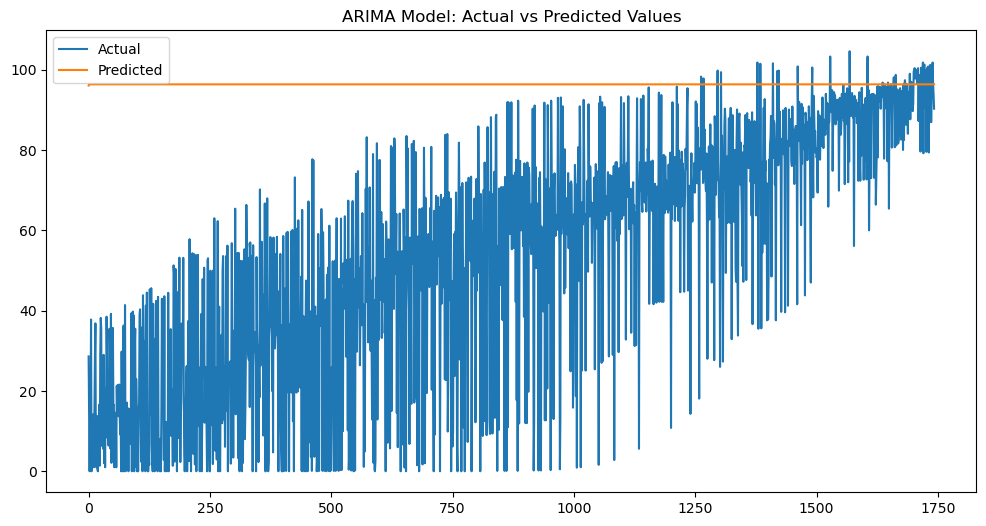

In [22]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Sort data by Year and Month to ensure time series order
X_train_sorted = pd.concat([y_train, X_train], axis=1).sort_values(['Year', 'Month'])
X_val_sorted = pd.concat([y_val, X_val], axis=1).sort_values(['Year', 'Month'])

# Fit ARIMA model
model = ARIMA(X_train_sorted['FoodPriceIndex'], order=(1,1,1))
results = model.fit()

# Make predictions
predictions = results.forecast(steps=len(y_val))

smape_arima = smape(X_val_sorted['FoodPriceIndex'].values, predictions.values)
print(f'sMAPE: {smape_arima:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(predictions.values, label='Predicted')
plt.title('ARIMA Model: Actual vs Predicted Values')
plt.legend()
plt.show()

c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ardav\miniconda3\envs\vsc\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


sMAPE: 75.75%


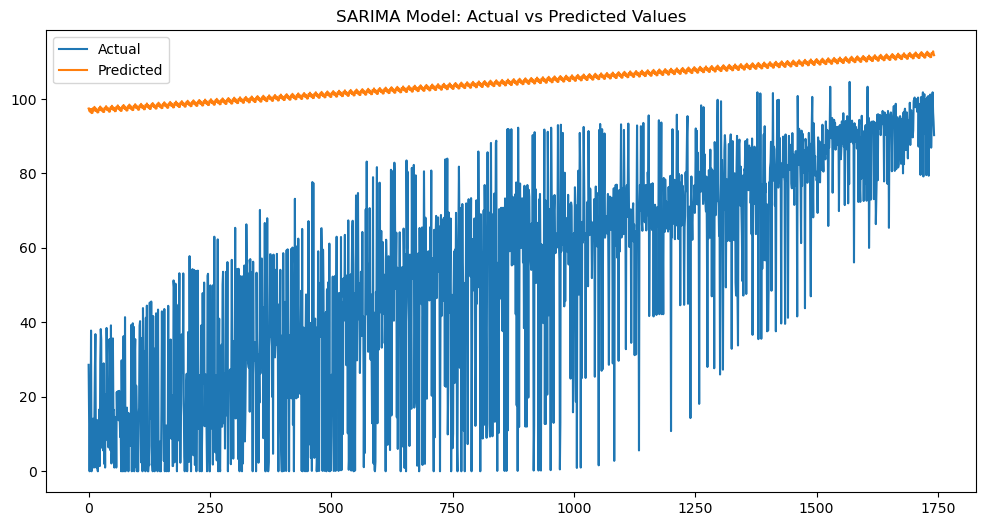

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sort data by Year and Month to ensure time series order
X_train_sorted = pd.concat([y_train, X_train], axis=1).sort_values(['Year', 'Month'])
X_val_sorted = pd.concat([y_val, X_val], axis=1).sort_values(['Year', 'Month'])

# Fit SARIMA model
# Using order=(1,1,1) for ARIMA part and seasonal_order=(1,1,1,12) for seasonal part
model = SARIMAX(X_train_sorted['FoodPriceIndex'], 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12))
results = model.fit()

# Make predictions
predictions = results.forecast(steps=len(y_val))

smape_sarima = smape(X_val_sorted['FoodPriceIndex'].values, predictions.values)
print(f'sMAPE: {smape_sarima:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(X_val_sorted['FoodPriceIndex'].values, label='Actual')
plt.plot(predictions.values, label='Predicted')
plt.title('SARIMA Model: Actual vs Predicted Values')
plt.legend()
plt.show()

18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:04 - cmdstanpy - INFO - Chain [1] done processing


sMAPE: 40.95%


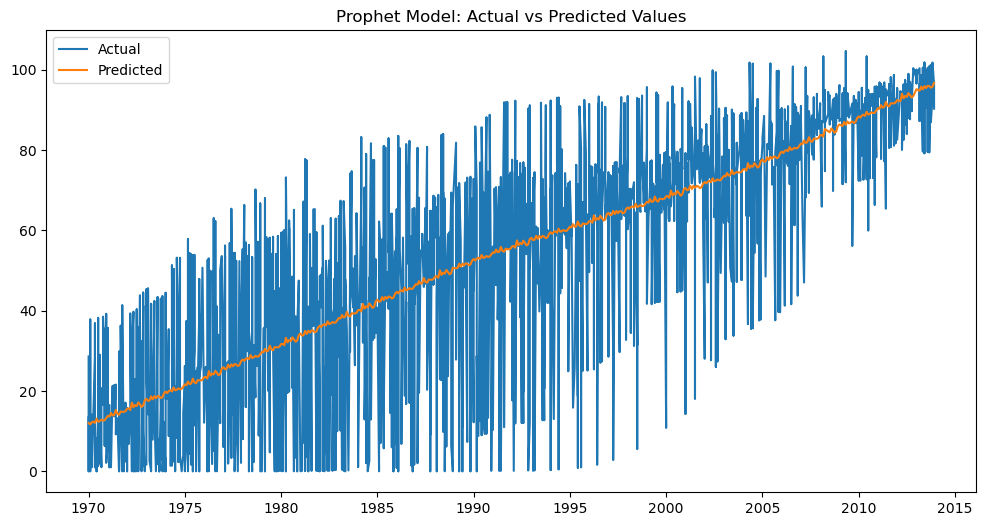

In [24]:
from prophet import Prophet

# Prepare data for Prophet (requires 'ds' and 'y' columns)
# Sort by date and reset index
prophet_train = pd.DataFrame({
    'ds': pd.to_datetime(X_train_sorted['Year'].astype(str) + '-' + X_train_sorted['Month'].astype(str) + '-01'),
    'y': X_train_sorted['FoodPriceIndex']
})

prophet_val = pd.DataFrame({
    'ds': pd.to_datetime(X_val_sorted['Year'].astype(str) + '-' + X_val_sorted['Month'].astype(str) + '-01'),
    'y': X_val_sorted['FoodPriceIndex']
})

# Fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_train)

# Make predictions
forecast = model.predict(prophet_val)

# Calculate sMAPE
smape_prophet = smape(prophet_val['y'].values, forecast['yhat'].values)
print(f'sMAPE: {smape_prophet:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(prophet_val['ds'], prophet_val['y'], label='Actual')
plt.plot(prophet_val['ds'], forecast['yhat'], label='Predicted')
plt.title('Prophet Model: Actual vs Predicted Values')
plt.legend()
plt.show()

In [25]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from sklearn.preprocessing import MinMaxScaler

# # Scale the data
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_sorted[['Country', 'Year', 'Month']])
# X_val_scaled = scaler.transform(X_val_sorted[['Country', 'Year', 'Month']])

# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1,1))
# y_val_scaled = y_scaler.transform(y_val.values.reshape(-1,1))

# # Reshape input data for LSTM [samples, time steps, features]
# X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

# # Build LSTM model
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(1, 3)),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss='mse')

# # Train the model
# history = model.fit(X_train_reshaped, y_train_scaled, 
#                    epochs=50,
#                    batch_size=32,
#                    validation_data=(X_val_reshaped, y_val_scaled),
#                    verbose=1)

# # Make predictions
# predictions_scaled = model.predict(X_val_reshaped)
# predictions = y_scaler.inverse_transform(predictions_scaled)

# # Calculate sMAPE
# smape_lstm = smape(y_val.values, predictions.flatten())
# print(f'sMAPE: {smape_lstm:.2f}%')

# # Plot results
# plt.figure(figsize=(12,6))
# plt.plot(y_val.values, label='Actual')
# plt.plot(predictions, label='Predicted')
# plt.title('LSTM Model: Actual vs Predicted Values')
# plt.legend()
# plt.show()

In [27]:
train_sorted = X_train_sorted.copy()
val_sorted = X_val_sorted.copy()


X_train_sorted = train_sorted.drop(['FoodPriceIndex'], axis=1)
y_train_sorted = train_sorted['FoodPriceIndex']

X_val_sorted = val_sorted.drop(['FoodPriceIndex'], axis=1)
y_val_sorted = val_sorted['FoodPriceIndex']

sMAPE: 1.23%


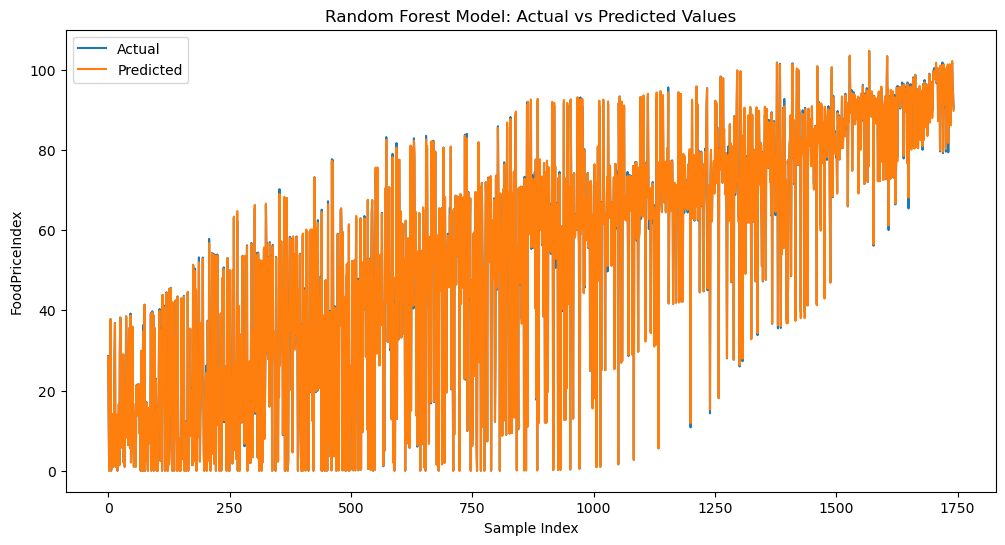


Feature Importance:
   feature  importance
1     Year    0.657628
0  Country    0.341522
2    Month    0.000850


In [37]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_sorted, y_train_sorted)

# Make predictions
rf_predictions = rf_model.predict(X_val_sorted)

# Calculate sMAPE
def smape(y_true, y_pred, epsilon=1e-10):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + epsilon))

smape_rf = smape(y_val_sorted.values, rf_predictions)
print(f'sMAPE: {smape_rf:.2f}%')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_val_sorted.reset_index(drop=True), label='Actual')
plt.plot(pd.Series(rf_predictions), label='Predicted')
plt.title('Random Forest Model: Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('FoodPriceIndex')
plt.legend()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_sorted.columns,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False))

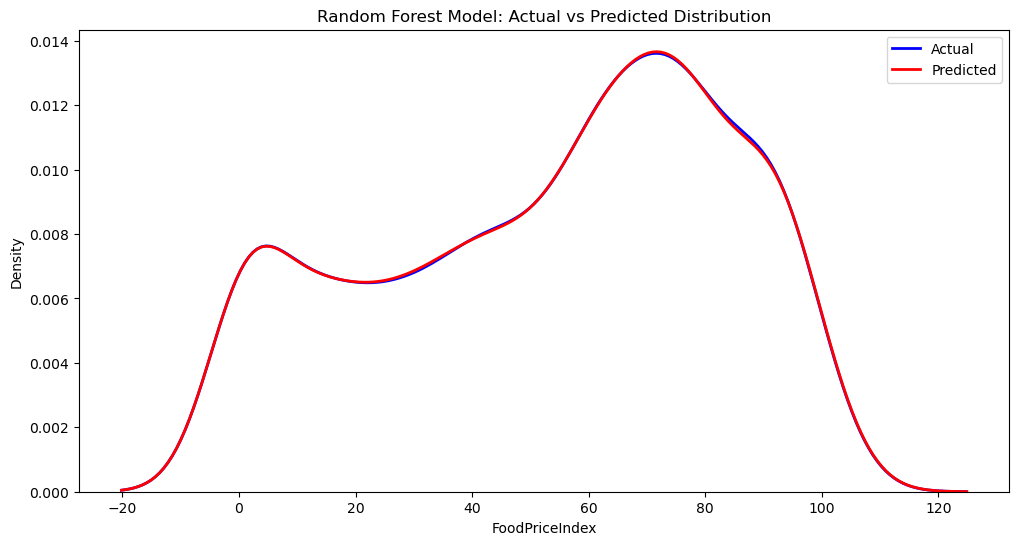

In [39]:
plt.figure(figsize=(12, 6))

sns.kdeplot(y_val_sorted, label='Actual', color='blue', linewidth=2)
sns.kdeplot(rf_predictions, label='Predicted', color='red', linewidth=2)
plt.title('Random Forest Model: Actual vs Predicted Distribution')
plt.xlabel('FoodPriceIndex')
plt.ylabel('Density')
plt.legend()
plt.show()


## Apply to test set

In [202]:
test.drop('id', axis=1, inplace=True)
test.head()

,Country,Year,Month
0,Italy,2023,4
1,Denmark,2022,7
2,United States,2019,6
3,Netherlands,2021,2
4,Italy,2019,8


In [203]:
# apply target encoding to test data
test = te.transform(test)
test.head()

,Country,Year,Month
0,52.826058,2023,4
1,59.620220,2022,7
2,55.972374,2019,6
3,71.658636,2021,2
4,52.826058,2019,8


In [204]:
# apply predictions
test['FoodPriceIndex'] = tuned_rf.predict(test)
test

,Country,Year,Month,FoodPriceIndex
0,52.826058,2023,4,98.535955
1,59.620220,2022,7,99.908427
2,55.972374,2019,6,96.212360
3,71.658636,2021,2,99.768156
4,52.826058,2019,8,99.687640
...,...,...,...,...
2635,62.380176,2022,2,99.716854
2636,59.620220,2020,4,99.976404
2637,43.869365,2017,1,100.021573
2638,43.869365,2020,3,100.433146


## Submit

In [205]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,FoodPriceIndex
0,99116,20.5
1,97687,20.5
2,92061,20.5
3,95122,20.5
4,92296,20.5


In [206]:
submission['FoodPriceIndex'] = test['FoodPriceIndex']
submission

,id,FoodPriceIndex
0,99116,98.535955
1,97687,99.908427
2,92061,96.212360
3,95122,99.768156
4,92296,99.687640
...,...,...
2635,96922,99.716854
2636,93502,99.976404
2637,87476,100.021573
2638,93366,100.433146


In [208]:
submission.to_csv("submission/submission_tuned_rf.csv", index=False)